# Explore data from the Appolo Grade 12 and Mars


This notebook is used to read all input data files, provide standardized Parquet files that will be used by the webapp.

This also serves as a standard definition should we decide to implement data from other sources such as Earth.

For this notebook to work, provided data should be in a directory `data` in the rootdir of this repo:

```text
project
│   README.md
│   space-apps-2024.yaml   
└───data (not commited)
│   └─lunar
│   │ └─test
│   │ └─training
│   │
│   └─mars
│     └─test
│     └─ (...)
└───out (created by this notebook)
└───plots (created by this notebook)


```

In [18]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import glob
import os
import re
from tqdm import tqdm

Start by configuring the notebook values...

In [19]:
planet = "lunar"
# planet = "mars"

data_prefix = "../data"
plot_prefix = "../plots"
out_prefix = "../out"

## Load and preprocess input files

### Label files

Provide the actual paths for the chosen dataset

In [20]:
if planet == "lunar":
    catalog_directory = os.path.join(data_prefix, 'lunar/training/catalogs/')
    catalog_file = catalog_directory + 'apollo12_catalog_GradeA_final.csv'
elif planet == "mars": 
    catalog_directory = os.path.join(data_prefix, 'mars/training/catalogs/')
    catalog_file = catalog_directory + 'Mars_InSight_training_catalog_final.csv'
else:
    raise RuntimeError("Don't know this planet")

Load and preprocess the label files

In [21]:

labels = pd.read_csv(catalog_file, parse_dates=['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
labels.rename(columns={"time_abs(%Y-%m-%dT%H:%M:%S.%f)":"datetime"}, inplace=True)
labels.set_index("datetime", inplace=True)

# In the case of mars data, we don't have any mq_type so we deal with this exception
try:
    mq_type_dict = {l:i+1 for i,l in enumerate(labels["mq_type"].unique())}
    print("MQ type label dictionnary:")
    print(mq_type_dict, "\n")
    labels["mq_type_id"] = labels["mq_type"].map(mq_type_dict)
except KeyError:
    labels["mq_type_id"] = 1


print("Here are the label data tables:")
labels

MQ type label dictionnary:
{'impact_mq': 1, 'deep_mq': 2, 'shallow_mq': 3} 

Here are the label data tables:


,filename,time_rel(sec),evid,mq_type,mq_type_id
datetime,,,,,
1970-01-19 20:25:00,xa.s12.00.mhz.1970-01-19HR00_evid00002,73500.0,evid00002,impact_mq,1
1970-03-25 03:32:00,xa.s12.00.mhz.1970-03-25HR00_evid00003,12720.0,evid00003,impact_mq,1
1970-03-26 20:17:00,xa.s12.00.mhz.1970-03-26HR00_evid00004,73020.0,evid00004,impact_mq,1
1970-04-25 01:14:00,xa.s12.00.mhz.1970-04-25HR00_evid00006,4440.0,evid00006,impact_mq,1
1970-04-26 14:29:00,xa.s12.00.mhz.1970-04-26HR00_evid00007,52140.0,evid00007,deep_mq,2
...,...,...,...,...,...
1974-10-14 17:43:00,xa.s12.00.mhz.1974-10-14HR00_evid00156,63780.0,evid00156,impact_mq,1
1975-04-12 18:15:00,xa.s12.00.mhz.1975-04-12HR00_evid00191,65700.0,evid00191,impact_mq,1
1975-05-04 10:05:00,xa.s12.00.mhz.1975-05-04HR00_evid00192,36300.0,evid00192,impact_mq,1


### Data files

In [22]:
data_directory = os.path.normpath(os.path.join(data_prefix, planet,'training/data'))
print(data_directory)
files  =  glob.glob(data_directory+"/**/*.csv", recursive=True)
dates = [re.search("\d{4}-\d{2}-\d{2}", file)[0] for file in files]

print("Available dates:")
print(dates)
print(f"{len(dates)} elements")

..\data\lunar\training\data
Available dates:
['1970-01-19', '1970-03-25', '1970-03-26', '1970-04-25', '1970-04-26', '1970-06-15', '1970-06-26', '1970-07-20', '1970-07-20', '1970-09-26', '1970-10-24', '1970-11-12', '1970-12-11', '1970-12-27', '1970-12-31', '1971-01-15', '1971-01-28', '1971-01-29', '1971-02-09', '1971-03-25', '1971-04-13', '1971-04-17', '1971-05-12', '1971-05-12', '1971-05-13', '1971-05-23', '1971-06-12', '1971-09-25', '1971-10-18', '1971-10-20', '1971-10-31', '1971-11-14', '1972-01-04', '1972-03-12', '1972-05-11', '1972-06-16', '1972-07-17', '1972-07-17', '1972-07-28', '1972-07-31', '1972-12-02', '1972-12-03', '1973-01-18', '1973-01-31', '1973-03-01', '1973-03-13', '1973-03-24', '1973-05-14', '1973-06-05', '1973-06-05', '1973-06-18', '1973-06-27', '1973-07-03', '1973-07-04', '1973-07-20', '1973-07-28', '1973-07-29', '1973-08-21', '1974-01-10', '1974-02-07', '1974-02-12', '1974-03-25', '1974-04-08', '1974-04-19', '1974-04-26', '1974-04-27', '1974-06-25', '1974-07-06', '1

In [23]:
def load_data(file, planet):
    date_col_dict = {"lunar": "time_abs(%Y-%m-%dT%H:%M:%S.%f)", 
                     "mars": "time(%Y-%m-%dT%H:%M:%S.%f)"}
    
    vel_col_dict = {"lunar": "velocity(m/s)", 
                     "mars": "velocity(c/s)"}
    
    data = pd.read_csv(file, parse_dates=[date_col_dict[planet]])
    data.rename(columns={date_col_dict[planet]:"datetime"}, inplace=True)
    data.rename(columns={vel_col_dict[planet]:"velocity"}, inplace=True)
    data.set_index("datetime", inplace=True)
    mask = (labels.index > data.index[0]) & (labels.index <= data.index[-1])
    data = data.join(labels.loc[mask, "mq_type_id"], how="outer")

    return data.loc[:, ["velocity", "mq_type_id"]]

## Packing and unpacking
### Export all dataframes to a parquet file

We chose Parquet for its storage efficiency and the speed at which we can read these files in the web app

In [24]:
# out_path = os.path.join(out_prefix, planet)
# os.makedirs(out_path, exist_ok=True)

# for file in (pbar := tqdm(files)):
#     sample_name = os.path.split(file)[1] 

#     data = load_data(file, planet)

#     out_file = os.path.split(file.replace(data_prefix, out_prefix).replace(".csv", ".parquet"))[1]
#     pbar.set_description(f"Writing {out_file}")   
#     data.to_parquet(os.path.join(out_path, out_file))
    

### Load all data files

This provides an example on how to read data, but also to emasure the read speed efficiency

In [25]:
# for file in (pbar := tqdm(files, unit="files")):
    
#     out_file = os.path.split(file.replace(data_prefix, out_prefix).replace(".csv", ".parquet"))[1]
#     pd.read_parquet(os.path.join(out_path, out_file))

In [26]:
# file = "../out/lunar/xa.s12.00.mhz.1970-09-26HR00_evid00013.parquet"
# data = pd.read_parquet(file)
# data.describe()


,velocity,mq_type_id
count,5.724180e+05,1.0
mean,-9.144855e-13,1.0
std,3.289989e-10,NaN
min,-1.208232e-08,1.0
25%,-1.002219e-10,1.0
50%,9.799797e-15,1.0
75%,1.038875e-10,1.0
max,1.242914e-08,1.0


... This is exactly the same data we had before packing/unpacking

## Diaplay:

Provide plots similar to those given with the dataset.

Small difference: we color-code the type of event.. just in case this proves to be useful.

In [27]:
# plot_path = os.path.join(plot_prefix, planet)
# os.makedirs(plot_path, exist_ok=True)

# c_dict = {1:"red", 
#           2:"orange",
#           3:"black"}

# for file in tqdm(files, unit="files"):
#     sample_name = os.path.split(file)[1] 

#     data = load_data(file, planet)

#     fig, ax = plt.subplots(figsize=(16, 5))

#     data["quakes"] = data["velocity"].max()*data["mq_type_id"]

#     data.plot(y=["velocity"], ax=ax, ylabel="Velocity", title=os.path.splitext(sample_name)[0])

#     qtimes = data["mq_type_id"].dropna().index
#     qtypes = data["mq_type_id"].dropna().values
#     for qtime, qtype in zip(qtimes, qtypes):
#         ax.axvline(x=qtime, c=c_dict[qtype])

#     plot_file = os.path.split(file.replace(data_prefix, plot_prefix).replace(".csv", ".png"))[1]    
#     fig.savefig(os.path.join(plot_path, plot_file), bbox_inches="tight")
#     plt.close(fig)

## Example of a filtering function

We provide here an exemplementation of a preprocessing / cleaning function, in order to implement in the web app backend.

These function expect a dataframe as those that can be read with the parquet files provided by this very notebook

The general pattern is 

```python
def clean_B(data, params):

    # Do stuff with data, with parameters in the dict param

    return data

```

In [28]:
# Util function

def calc_sampling_freq(df):
    t_s = df["velocity"].index.diff().median().total_seconds()

    return 1/t_s

In [29]:
from scipy.signal import butter, lfilter, filtfilt

def bandpass_filter(dataframe, **kwargs):
    
    fs = calc_sampling_freq(dataframe)

    b, a = butter(kwargs["order"], [kwargs["f_lo"], kwargs["f_hi"]], fs=fs, btype='band')

    data_out = dataframe.copy()
    data_out["velocity"] = lfilter(b, a, dataframe["velocity"])

    return data_out

In [102]:
from scipy.signal import find_peaks

def remove_peaks(dataframe, **kwargs):


    freq = calc_sampling_freq(dataframe)
    
    dataframe_max = max(dataframe["velocity"])
    dataframe_min = min(dataframe["velocity"])

    abs_max = max(dataframe_max, abs(dataframe_min))

    wlen = kwargs["prominence_valley_time"] * freq # prominence_valley_time [s] * freq [samples/sec]

    peaks, props = find_peaks(abs(dataframe["velocity"]),
                            width=[kwargs["width_time_min"]*freq, kwargs["width_time_max"]*freq],
                            distance=kwargs["distance_time"]*freq,
                            prominence=kwargs["prominence_percent"]/100*abs_max,
                            wlen=wlen)
    
    data_out = dataframe.copy()
    for peak in peaks:
        data_out.iloc[peak-1000:peak+1000] = 0

    return data_out

In [103]:
from obspy.signal.filter import lowpass

def lowpass_filter(dataframe, **kwargs):
    data_out = dataframe.copy()

    freq = calc_sampling_freq(dataframe)

    data_out["velocity"] = lowpass(dataframe["velocity"], kwargs["frequency"], freq, kwargs["filter_order"], kwargs["zerophase"])

    return data_out


In [104]:
from obspy.signal.filter import  highpass

def highpass_filter(dataframe, **kwargs):
    data_out = dataframe.copy()

    freq = calc_sampling_freq(dataframe)

    data_out["velocity"] = highpass(data_out, kwargs["frequency"], freq, kwargs["filter_order"], kwargs["zerophase"])

    return data_out
file = "../out/lunar/xa.s12.00.mhz.1970-09-26HR00_evid00013.parquet"
data = pd.read_parquet(file)
data.describe()


,velocity,mq_type_id
count,5.724230e+05,1.0
mean,-4.878679e-13,1.0
std,2.773968e-10,NaN
min,-4.711333e-09,1.0
25%,-1.240515e-10,1.0
50%,-4.036001e-13,1.0
75%,1.144970e-10,1.0
max,4.496015e-09,1.0


## TESTING AREA

In [105]:
file = "../out/lunar/xa.s12.00.mhz.1970-10-24HR00_evid00014.parquet"
data = pd.read_parquet(file)
data.describe()

,velocity,mq_type_id
count,5.724200e+05,1.0
mean,-1.523585e-12,1.0
std,4.220413e-10,NaN
min,-1.707915e-08,1.0
25%,-1.375685e-10,1.0
50%,1.811865e-14,1.0
75%,1.396554e-10,1.0
max,1.507133e-08,1.0


In [106]:
freq = calc_sampling_freq(data)

kwargs = {"f_lo":0.1, "f_hi":freq/2.1, "order":4}
kwargs_2 = {"prominence_percent":60, "prominence_valley_time":15, "distance_time":1, "width_time_min":0, "width_time_max": 15}

data_f = remove_peaks(data, **kwargs_2)
# data_f = bandpass_filter(data, **kwargs)



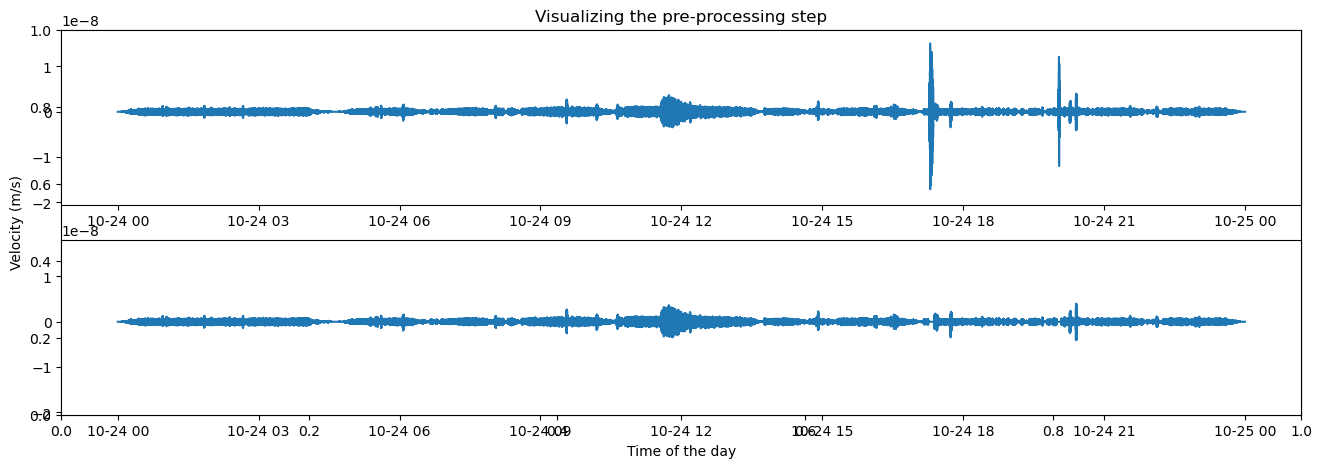

In [107]:
fig= plt.figure(figsize=(16, 5))

plt.title("Visualizing the pre-processing step")
plt.xlabel("Time of the day")
plt.ylabel("Velocity (m/s)")

min_value = min(data.velocity)
max_value = max(data.velocity)

ax = plt.subplot(2, 1, 1)
ax.plot(data.velocity)
ax.set_ylim([min_value*1.2, max(data.velocity)*1.2])

ax2 = plt.subplot(2, 1, 2)
ax2.plot(data_f.velocity)
ax2.set_ylim([min_value*1.2, max(data.velocity)*1.2])


plt.show()